# Linear Regression Analysis
**Name:** Sarah Ibadi

**Class:** CS4372.501

This page contains the Python code. I uploaded the chosen dataset into GitHub and plugged the raw link into the `DATA_URL` variable.


## Dataset Choice
- **Source:** UCI Machine Learning Repository — **Student Performance** (student-mat.csv)
- **Task:** Regression
- **Output Target predictions:** `G3` (final grade, 0–20)
- **Key predictors examples:**
  - Prior grades: `G1`, `G2` (highly correlated with `G3`)
  - Demographics & school info: `school`, `sex`, `age`, `address`, `famsize`, `Pstatus`
  - Family/parental: `Medu`, `Fedu`, `Mjob`, `Fjob`, `guardian`
  - Academics & support: `studytime`, `failures`, `schoolsup`, `famsup`, `paid`, `activities`, `higher`, `internet`, `nursery`
  - Social/health: `famrel`, `freetime`, `goout`, `Dalc`, `Walc`, `health`, `absences`



## 1. Setup & Imports
- import numpy & pandas

In [11]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import statsmodels.api as sm
import statsmodels.tools.tools as sm_tools

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)
print('Python', sys.version)
print('Pandas', pd.__version__)

Python 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Pandas 2.2.2


## 2. Load Data from Public URL


In [12]:
DATA_URL = 'https://raw.githubusercontent.com/sarahibadi/Student-Performance-Dataset/refs/heads/main/student-mat.csv'

CSV_SEP = ';'

df = pd.read_csv(DATA_URL, sep=CSV_SEP)
print('Data shape:', df.shape)
df.head()

Data shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


## 3. Data Integrity Checks & Cleaning

In [13]:
display(df.info())
display(df.describe(include='all'))
null_counts = df.isna().sum().sort_values(ascending=False)
print('Null counts (top):')
display(null_counts.head(10))

df_clean = df.copy()
for col in df_clean.columns:
    if df_clean[col].dtype.kind in 'bifc':
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    else:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode().iloc[0])

print('Any remaining nulls?', df_clean.isna().any().any())
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

None

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395,395,395.000000,395,395,395,395.000000,395.000000,395,395,395,395,395.000000,395.000000,395.000000,395,395,395,395,395,395,395,395,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
unique,2,2,NaN,2,2,2,NaN,NaN,5,5,4,3,NaN,NaN,NaN,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,GP,F,NaN,U,GT3,T,NaN,NaN,other,other,course,mother,NaN,NaN,NaN,no,yes,no,yes,yes,yes,yes,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,349,208,NaN,307,281,354,NaN,NaN,141,217,145,273,NaN,NaN,NaN,344,242,214,201,314,375,329,263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,16.696203,NaN,NaN,NaN,2.749367,2.521519,NaN,NaN,NaN,NaN,1.448101,2.035443,0.334177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,NaN,NaN,1.276043,NaN,NaN,NaN,1.094735,1.088201,NaN,NaN,NaN,NaN,0.697505,0.839240,0.743651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,NaN,NaN,15.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,NaN,NaN,16.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,NaN,NaN,17.000000,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,NaN,NaN,18.000000,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,NaN,NaN,2.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000


Null counts (top):


,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


Any remaining nulls? False


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


## 4. Attributes & Target
- `TARGET_COL` is set to `G3` ,the response variable
- Seperate categorical and numerical
- Distribution checks

Numeric features: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']
Categorical features: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


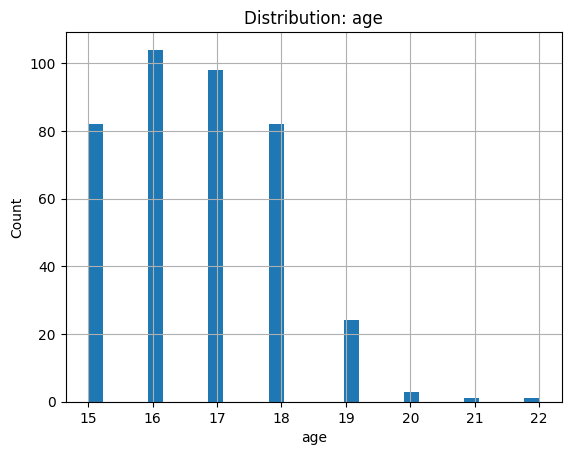

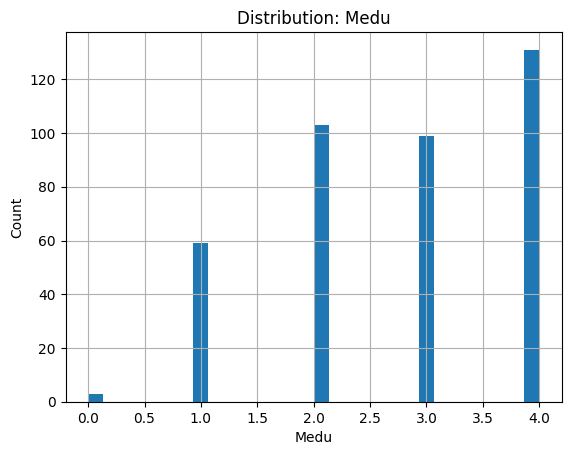

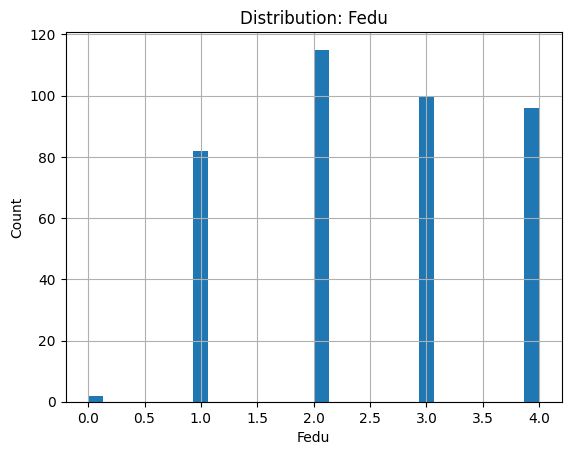

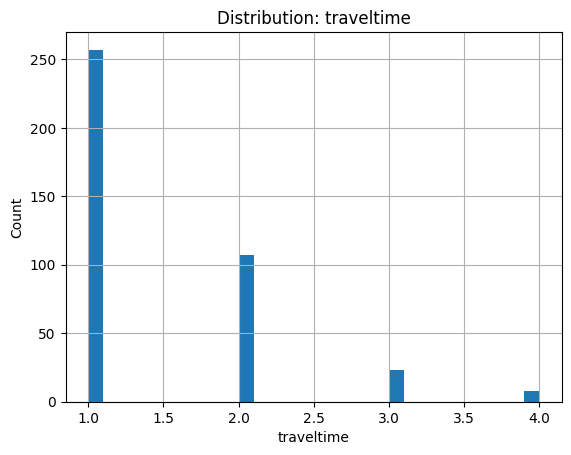

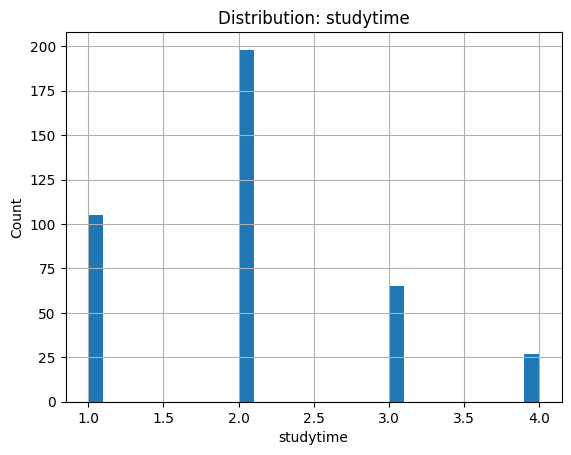

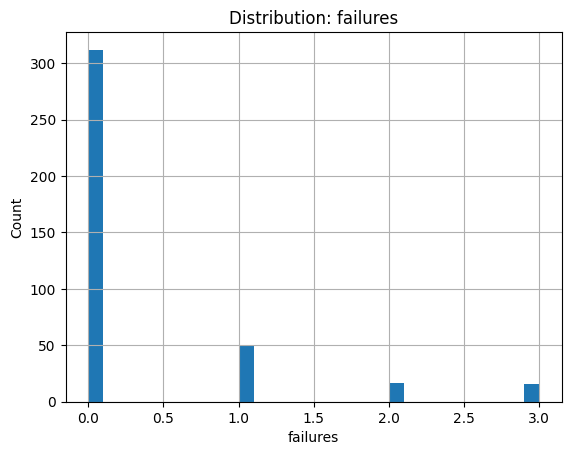

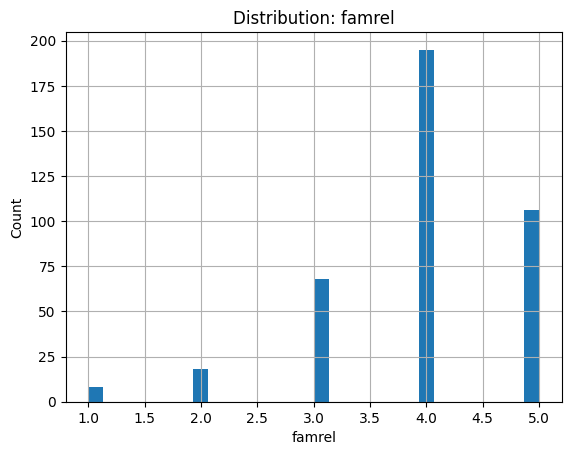

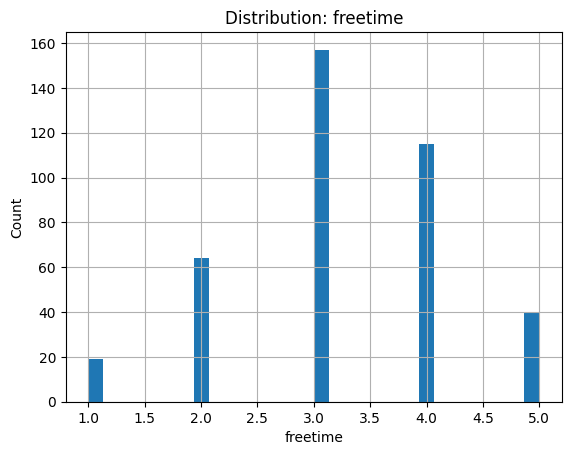

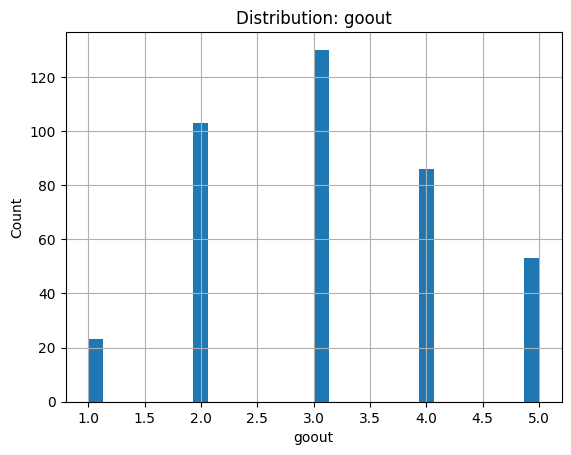

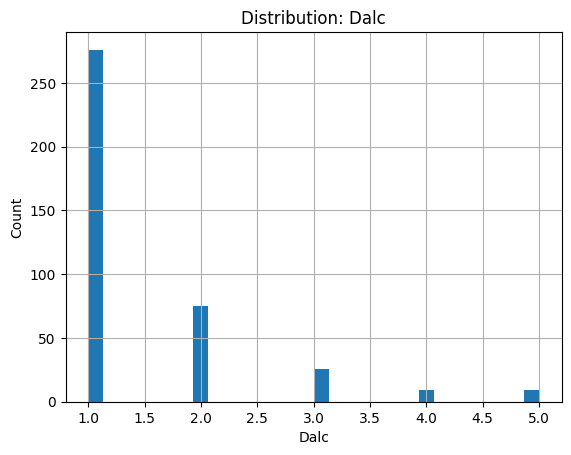

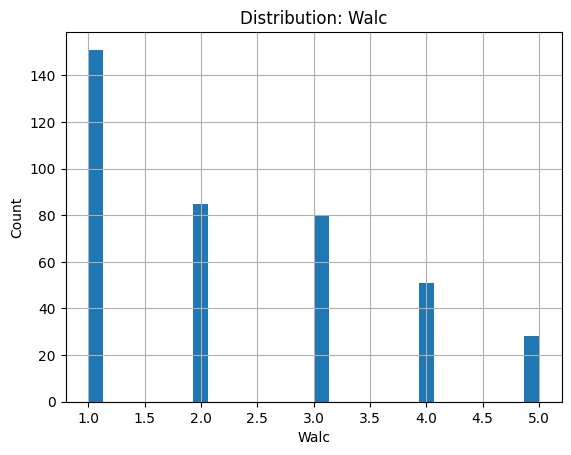

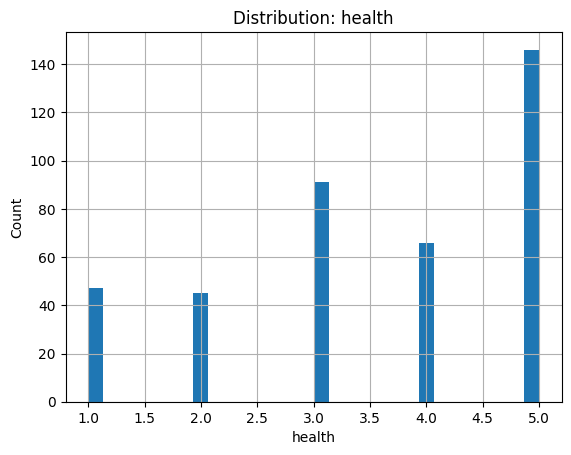

In [14]:
TARGET_COL = 'G3'

assert TARGET_COL in df_clean.columns, f'Target column {TARGET_COL} not in columns!'

y = df_clean[TARGET_COL]
X = df_clean.drop(columns=[TARGET_COL])

numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]
print('Numeric features:', numeric_cols)
print('Categorical features:', categorical_cols)

for col in numeric_cols[:12]:
    plt.figure()
    X[col].hist(bins=30)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

## 5. Standardize / Normalize & Correlation Analysis


Correlation with target:


,G3
G3,1.000000
G2,0.904868
G1,0.801468
Medu,0.217147
Fedu,0.152457
studytime,0.097820
famrel,0.051363
absences,0.034247
freetime,0.011307
Walc,-0.051939


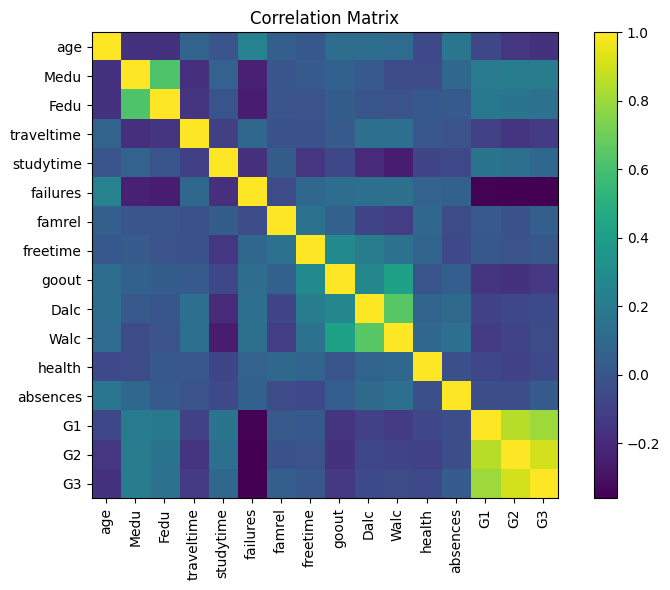

In [15]:
corrs = df_clean[numeric_cols + [TARGET_COL]].corr()
print('Correlation with target:')
display(corrs[TARGET_COL].sort_values(ascending=False))

plt.figure(figsize=(8,6))
cax = plt.imshow(corrs.values, interpolation='nearest')
plt.title('Correlation Matrix')
plt.colorbar(cax)
plt.xticks(range(len(corrs.columns)), corrs.columns, rotation=90)
plt.yticks(range(len(corrs.columns)), corrs.columns)
plt.tight_layout()
plt.show()

## 6. Feature Selection (Simple Heuristic)


In [16]:
TOP_K = min(8, len(numeric_cols))
abs_corr = corrs[TARGET_COL].abs().sort_values(ascending=False)
top_features = [c for c in abs_corr.index if c != TARGET_COL][:TOP_K]
print('Top features (by |corr|):', top_features)

selected_features = top_features + categorical_cols
X_sel = X[selected_features].copy()
print('X_sel shape:', X_sel.shape)
X_sel.head()

Top features (by |corr|): ['G2', 'G1', 'failures', 'Medu', 'age', 'Fedu', 'goout', 'traveltime']
X_sel shape: (395, 25)


,G2,G1,failures,Medu,age,Fedu,goout,traveltime,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,6,5,0,4,18,4,4,2,GP,F,U,GT3,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,5,5,0,1,17,1,3,1,GP,F,U,GT3,T,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,8,7,3,1,15,1,2,1,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,yes,no,yes,yes,yes,no
3,14,15,0,4,15,2,2,1,GP,F,U,GT3,T,health,services,home,mother,no,yes,yes,yes,yes,yes,yes,yes
4,10,6,0,3,16,3,2,1,GP,F,U,GT3,T,other,other,home,father,no,yes,yes,no,yes,yes,no,no


## 7. Train / Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.2, random_state=42
)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (316, 25)
X_test shape: (79, 25)


## 8. SGDRegressor Model + Hyperparameter Tuning
- Pipeline: preprocess (OneHot for categoricals, StandardScaler for numerics) + SGDRegressor
- GridSearchCV over learning rate, alpha, penalty, loss, etc.
- Log experiments.

In [21]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [c for c in X_sel.columns if c in numeric_cols]),
        ('cat', categorical_transformer, [c for c in X_sel.columns if c in categorical_cols]),
    ]
)

pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', SGDRegressor(random_state=42))
])

param_grid = {
    'model__penalty': ['l2', 'elasticnet'],
    'model__alpha': [1e-4, 1e-3],
    'model__loss': ['squared_error', 'huber'],
    'model__learning_rate': ['optimal', 'adaptive'],
    'model__eta0': [0.01, 0.1],
    'model__max_iter': [1000],
    'model__early_stopping': [True],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

grid.fit(X_train, y_train)

print('Best params:', grid.best_params_)
print('Best CV R^2:', grid.best_score_)

best_model = grid.best_estimator_

y_pred_tr = best_model.predict(X_train)
y_pred_te = best_model.predict(X_test)

metrics = {
    'train_R2': r2_score(y_train, y_pred_tr),
    'test_R2': r2_score(y_test, y_pred_te),
    'train_RMSE': mean_squared_error(y_train, y_pred_tr)**0.5,
    'test_RMSE': mean_squared_error(y_test, y_pred_te)**0.5,
    'train_MAE': mean_absolute_error(y_train, y_pred_tr),
    'test_MAE': mean_absolute_error(y_test, y_pred_te),
}
print('Metrics:', metrics)

residuals = y_test - y_pred_te
plt.figure()
plt.scatter(y_pred_te, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals (y - y_hat)')
plt.title('SGDRegressor Residuals (Test)')
plt.show()

cv_results = pd.DataFrame(grid.cv_results_)
cv_results.sort_values('rank_test_score').head(10)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


KeyboardInterrupt: 

## 9. OLS (statsmodels) — Model, Summary & Diagnostics
- Build OLS on a standardized design matrix (numeric + encoded categoricals)
- Output summary and basic diagnostics (residual plots)
- Interpreted coefficients, p-values, R², Adj. R², F-statistic in my report

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     48.08
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           1.69e-97
Time:                        08:34:34   Log-Likelihood:                -626.17
No. Observations:                 316   AIC:                             1322.
Df Residuals:                     281   BIC:                             1454.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2302      0.052     23.502      0.0

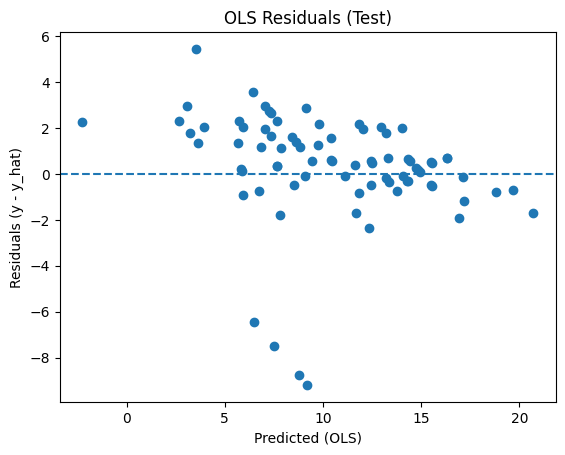

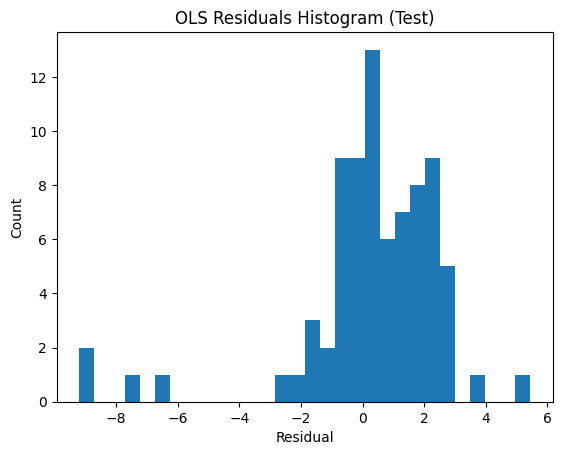

In [19]:
preprocess_ols = preprocess.fit(X_train)
X_train_ols = preprocess_ols.transform(X_train)
X_test_ols = preprocess_ols.transform(X_test)

X_train_ols = sm_tools.add_constant(X_train_ols, has_constant='add')
X_test_ols = sm_tools.add_constant(X_test_ols, has_constant='add')

ols_model = sm.OLS(y_train.values, X_train_ols)
ols_res = ols_model.fit()
print(ols_res.summary())

y_pred_tr_ols = ols_res.predict(X_train_ols)
y_pred_te_ols = ols_res.predict(X_test_ols)

ols_metrics = {
    'train_R2': r2_score(y_train, y_pred_tr_ols),
    'test_R2': r2_score(y_test, y_pred_te_ols),
    'train_RMSE': mean_squared_error(y_train, y_pred_tr_ols)**0.5,
    'test_RMSE': mean_squared_error(y_test, y_pred_te_ols)**0.5,
    'train_MAE': mean_absolute_error(y_train, y_pred_tr_ols),
    'test_MAE': mean_absolute_error(y_test, y_pred_te_ols)
}
print('OLS metrics:', ols_metrics)

ols_residuals = y_test - y_pred_te_ols
plt.figure()
plt.scatter(y_pred_te_ols, ols_residuals)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted (OLS)')
plt.ylabel('Residuals (y - y_hat)')
plt.title('OLS Residuals (Test)')
plt.show()

plt.figure()
plt.hist(ols_residuals, bins=30)
plt.title('OLS Residuals Histogram (Test)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

## 10. Saved Experiment Logs
- Saved results

In [20]:
cv_results_out = 'sgd_cv_results.csv'
pd.DataFrame(grid.cv_results_).to_csv(cv_results_out, index=False)
print('Wrote', cv_results_out)

summary_metrics = pd.DataFrame([
    {'model':'SGDRegressor (best)', **metrics},
    {'model':'OLS', **ols_metrics}
])
summary_metrics_out = 'summary_metrics.csv'
summary_metrics.to_csv(summary_metrics_out, index=False)
print('Wrote', summary_metrics_out)
summary_metrics

Wrote sgd_cv_results.csv
Wrote summary_metrics.csv


,model,train_R2,test_R2,train_RMSE,test_RMSE,train_MAE,test_MAE
0,SGDRegressor (best),0.824443,0.782969,1.920283,2.109558,0.996669,1.152838
1,OLS,0.853320,0.720943,1.755263,2.392086,1.167936,1.592822
